In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
def ts_train_test_normalize(all_tsla_data, time_steps, for_periods,trainStart,trainEnd,testStart,testEnd):
    
    # create training and test set 
    ts_train = all_tsla_data[trainStart:trainEnd].iloc[:,0:1].values
    ts_test = all_tsla_data[testStart:testEnd].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    #print("1:", ts_train)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train)
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):
        X_train.append(ts_train_scaled[i-time_steps:i, 0])
        y_train.append(ts_train_scaled[i:i+for_periods, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    #print("2:", X_train)
    
    # Reshaping X_train for efficient modelling 
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    inputs = pd.concat((all_tsla_data["Adj Close"][trainStart:trainEnd], all_tsla_data["Adj Close"][testStart:testEnd]), axis=0).values
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

In [3]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from keras.models import Sequential
    from keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')
    
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    return my_LSTM_model, LSTM_prediction 

In [195]:
def actual_pred_plot(preds,testStart,testEnd):
    """
    Plot the actual vs predition
    """
    index= 0
    for i in range(0,len(all_tsla_data.index)):
        if all_tsla_data.index[i] == testEnd:
            index = i
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_tsla_data.loc[testStart:all_tsla_data.index[index+1],'Adj Close'][0:len(preds)]
    actual_pred['prediction'] = preds[:,0]
    
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot().get_figure())

In [196]:
all_tsla_data.index[0]

'2010-06-29'

In [122]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from keras.models import Sequential 
    from keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [124]:
#get tesla stock data
all_tsla_data = pd.read_csv('TSLA.csv')
all_tsla_data = all_tsla_data.set_index("Date")
cols = all_tsla_data.columns.tolist()
all_tsla_data = all_tsla_data[cols[-2:-1]+cols[:4]+cols[5:]]
#all_tsla_data

In [197]:
#use time parameters to make train and test set
trainStart = '2012-01-02'
trainEnd = '2015-12-20'
testStart = '2015-12-25'
testEnd = '2016-02-20'
X_train, y_train, X_test, sc = ts_train_test_normalize(all_tsla_data, 5,2,trainStart,trainEnd,testStart,testEnd)


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


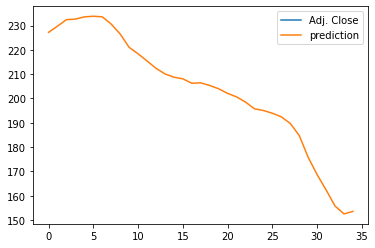

In [198]:
#Use LSTM model
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
LSTM_prediction[1:10]
t1,t2 = actual_pred_plot(LSTM_prediction,testStart,testEnd)

In [188]:
all_tsla_data.index['2012-01-02']

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [116]:
t2

<AxesSubplot:xlabel='Date'>

In [10]:
#LSTM accuracy and evaluation
y_pred = pd.DataFrame(LSTM_prediction[:, 0])
y_test=all_tsla_data.loc[testStart:testEnd,'Adj Close'][0:len(LSTM_prediction)]
y_test.reset_index(drop=True, inplace=True)
confirm_result(y_test, y_pred)

,Results
MAE,7.31337
RMSE,8.99015
RMSLE,0.03898
R2,0.85736


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


(61.24693, <AxesSubplot:xlabel='Date'>)

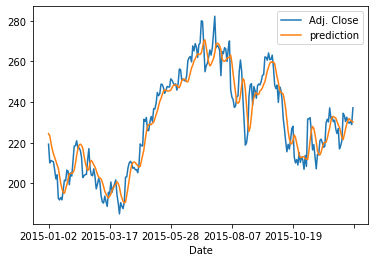

In [11]:
#GRU model
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction,testStart,testEnd)

In [12]:
#GRU accuracy and evaluation
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=all_tsla_data.loc[testStart:testEnd,'Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,6.15938
RMSE,7.82604
RMSLE,0.03393
R2,0.89191


In [13]:
from tkinter import *

<AxesSubplot:xlabel='Date'>

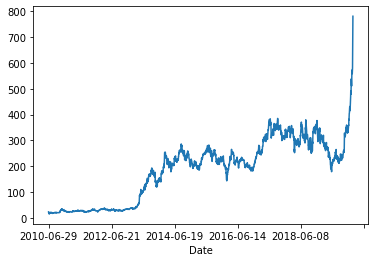

In [154]:
all_tsla_data["Adj Close"].plot()

In [80]:
def changeToDate(i):
    return all_tsla_data[0]

In [90]:
len(all_tsla_data.index)

2416

In [65]:
from tkinter import *

win = Tk()
win.geometry("1000x1000")
win.title("stok prediction AI model")
win.option_add("*Font","arial")
char = ['a','b','c','d','e','f']
def show_values():
    print(w1.get(), w2.get())

def alert():
    print("pressed")

def slider_changed(event):  
    print(scale.get())
current_value = DoubleVar()
value = DoubleVar()
scale = Scale(win, from_=0, to=42,command = slider.get)
scale.pack()
#btn = Button(win, text="predict",command=show_values)
print(current_value)
#btn.pack()
win.mainloop()

PY_VAR23


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\ProgramData\Anaconda3\lib\tkinter\ttk.py", line 1096, in get
    return self.tk.call(self._w, 'get', x, y)
_tkinter.TclError: invalid command name ".!scale"
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\ProgramData\Anaconda3\lib\tkinter\ttk.py", line 1096, in get
    return self.tk.call(self._w, 'get', x, y)
_tkinter.TclError: invalid command name ".!scale"
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "C:\ProgramData\Anaconda3\lib\tkinter\ttk.py", line 1096, in get
    return self.tk.call(self._w, 'get', x, y)
_tkinter.TclError: in

In [ ]:
import tkinter as tk
from tkinter import ttk

root = tk.Tk()
root.geometry('300x200')
root.resizable(False, False)
root.title('Slider Demo')

current_value = tk.DoubleVar()

def slider_changed(event):  
    print(slider.get())

slider = ttk.Scale(
    root,
    from_=0,
    to=100,
    orient='horizontal',
    variable=current_value
    command=slider_changed
)

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


       Results
MAE   10.57262
RMSE  14.47243
RMSLE  0.05638
R2     0.81445


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


       Results
MAE    5.80714
RMSE   7.70146
RMSLE  0.03181
R2     0.94746


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


       Results
MAE   10.27037
RMSE  13.55597
RMSLE  0.04307
R2     0.76645


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


       Results
MAE   13.81220
RMSE  17.74691
RMSLE  0.05554
R2     0.59972


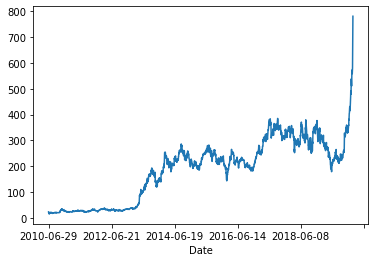

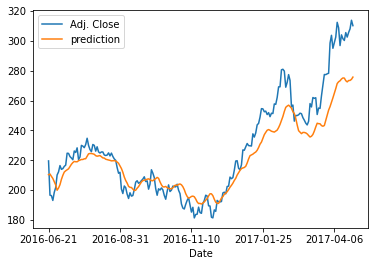

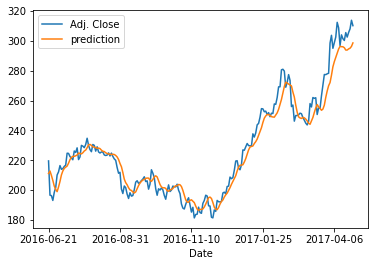

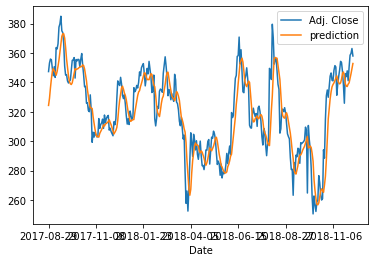

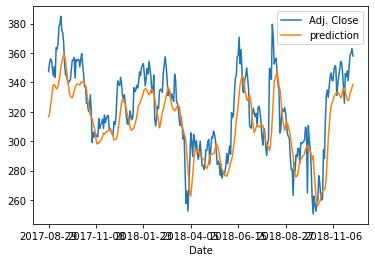

In [236]:
import tkinter as tk
from tkinter import ttk


# root window
root = tk.Tk()
root.geometry('600x1000')
root.resizable(False, False)
root.title('Demo')


root.columnconfigure(0, weight=1)
root.columnconfigure(1, weight=3)


# slider current value
current_value = tk.IntVar()
current_value2 = tk.IntVar()
current_value3 = tk.IntVar()
current_value4 = tk.IntVar()

p1 = all_tsla_data["Adj Close"].plot().get_figure()
plot1 = FigureCanvasTkAgg(p1, root)
plot1.get_tk_widget().grid(row=0,column=1,padx=30,pady=0)
#plot1.get_tk_widget().place(relx=0.5, rely=0, anchor=CENTER)
  
    
def get_current_value():
    return '{: .2f}'.format(current_value.get())
def get_current_value2():
    return '{: .2f}'.format(current_value2.get())
def get_current_value3():
    return '{: .2f}'.format(current_value3.get())
def get_current_value4():
    return '{: .2f}'.format(current_value4.get())


def slider_changed(event):
    v = get_current_value()
    v = v.replace(' ','')
    v = v.replace('.00','')
    v = int(v)
    trains = v
    current_value_label.configure(text="Start Date:"+ all_tsla_data.index[v])
def slider_changed2(event):
    v = get_current_value2()
    v = v.replace(' ','')
    v = v.replace('.00','')
    v = int(v)
    traine = v
    current_value_label2.configure(text="End Date:"+ all_tsla_data.index[v])
def slider_changed3(event):
    v = get_current_value3()
    v = v.replace(' ','')
    v = v.replace('.00','')
    v = int(v)
    tests = v
    current_value_label3.configure(text="Start Date:"+ all_tsla_data.index[v])
def slider_changed4(event):
    v = get_current_value4()
    v = v.replace(' ','')
    v = v.replace('.00','')
    v = int(v)
    teste = v
    current_value_label4.configure(text="End Date:"+ all_tsla_data.index[v])

def changeToInt(v):
    v = v.replace(' ','')
    v = v.replace('.00','')
    v = int(v)
    return v
def check1():
    if agreement.get() == 'LSTM':
        agreement2.set("LSTM")
def check2():
    if agreement.get() == 'GRU':
        agreement2.set("GRU")
# label for the slider
slider_label = ttk.Label(
    root,
    text='Train Start'
)

slider_label.grid(
    column=0,
    row=1,
    
    sticky='w'
)

slider_label2 = ttk.Label(
    root,
    text='Train end'
)

slider_label2.grid(
    column=0,
    row=3,
    sticky='w'
)

slider_label3 = ttk.Label(
    root,
    text='Test Start'
)

slider_label3.grid(
    column=0,
    row=5,
    sticky='w'
)

slider_label4 = ttk.Label(
    root,
    text='Test End'
)

slider_label4.grid(
    column=0,
    row=7,
    sticky='w'
)



#  slider
slider = ttk.Scale(
    root,
    from_=0,
    to=2415,
    orient='horizontal',  # vertical
    command=slider_changed,
    variable=current_value
)

slider.grid(
    column=1,
    row=1,
    sticky='we'
)

slider2 = ttk.Scale(
    root,
    from_=0,
    to=2415,
    orient='horizontal',  # vertical
    command=slider_changed2,
    variable=current_value2
)

slider2.grid(
    column=1,
    row=3,
    sticky='we'
)

slider3 = ttk.Scale(
    root,
    from_=0,
    to=2415,
    orient='horizontal',  # vertical
    command=slider_changed3,
    variable=current_value3
)

slider3.grid(
    column=1,
    row=5,
    sticky='we'
)

slider4 = ttk.Scale(
    root,
    from_=0,
    to=2415,
    orient='horizontal',  # vertical
    command=slider_changed4,
    variable=current_value4
)

slider4.grid(
    column=1,
    row=7,
    sticky='we'
)

# current value label
current_value_label = ttk.Label(
    root,
    text='Start Date'+ get_current_value()
)

current_value_label.grid(
    row=2,
    columnspan=2,
    sticky='n',
    ipadx=10,
    ipady=10
)

current_value_label2 = ttk.Label(
    root,
    text='End Date'+ get_current_value2()
)

current_value_label2.grid(
    row=4,
    columnspan=2,
    sticky='n',
    ipadx=10,
    ipady=10
)
current_value_label3 = ttk.Label(
    root,
    text='Start Date'+ get_current_value3()
)

current_value_label3.grid(
    row=6,
    columnspan=2,
    sticky='n',
    ipadx=10,
    ipady=10
)
current_value_label4 = ttk.Label(
    root,
    text='End Date'+ get_current_value4()
)

current_value_label4.grid(
    row=8,
    columnspan=2,
    sticky='n',
    ipadx=10,
    ipady=10
)
tests = get_current_value()
teste = 0
trains = 0
traine = 0
ttk.Style().configure("TButton", padding=6, relief="flat",
   background="#ccc")
agreement = tk.StringVar()
agreement2 = tk.StringVar()
checkbox1 = ttk.Checkbutton(root,
                text='LSTM',
                variable=agreement,
                command = check1,
                onvalue='LSTM',
                offvalue='GRU')
checkbox1.grid(row=10,column=0)
agreement.set("LSTM")
checkbox2 = ttk.Checkbutton(root,
                text='GRU',
                variable=agreement,
                command = check2,
                onvalue='GRU',
                offvalue='LSTM')
checkbox2.grid(row=10,column=1)
def updatePredictionImage():
    trains = all_tsla_data.index[changeToInt(get_current_value())]
    traine = all_tsla_data.index[changeToInt(get_current_value2())]
    tests = all_tsla_data.index[changeToInt(get_current_value3())]
    teste = all_tsla_data.index[changeToInt(get_current_value4())]
    X_train, y_train, X_test, sc = ts_train_test_normalize(all_tsla_data, 5,2,trains,traine,tests,teste)
    if agreement.get() == "LSTM":
        my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
        t1,t2 = actual_pred_plot(LSTM_prediction,tests,teste)
        y_pred = pd.DataFrame(LSTM_prediction[:, 0])
        y_test=all_tsla_data.loc[tests:teste,'Adj Close'][0:len(LSTM_prediction)]
        y_test.reset_index(drop=True, inplace=True)
        print(confirm_result(y_test, y_pred))
    else:
        my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
        t1,t2 = actual_pred_plot(GRU_prediction,tests,teste)
        y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
        y_test_gru=all_tsla_data.loc[tests:teste,'Adj Close'][0:len(GRU_prediction)]
        y_test_gru.reset_index(drop=True, inplace=True)
        print(confirm_result(y_test_gru, y_pred_gru))
    plot2 = FigureCanvasTkAgg(t2, root)
    plot2.get_tk_widget().grid(row=10,column=1,padx=30,pady=0)
    plot2.get_tk_widget().place(relx=0.5, rely=0.8, anchor=CENTER)
    
btn = ttk.Button(text="Predict!",command = updatePredictionImage)
btn.grid(row=9,column=0)
btn.place(relx=0.5, rely=0.6, anchor=CENTER)



root.mainloop()

In [234]:
LMAE = np.mean([2.01016,8.12539,69.99676,23.09873,1.97902,23.03876,73.05962,68.46806,17.45957,22.17376])
LRMSE = np.mean([2.51849,10.44648,75.26966,26.24490,2.41775,32.72954,74.51945,71.41315,20.96271,27.87136])
LRMSLE = np.mean([0.08151,0.04940,0.25775,0.08047,0.07791,0.12573,0.24567,0.23921,0.06249,0.08740])
LR2 = np.mean([-1.01089,0.79785,-3.39552,0.28118,-0.80672,0.35499,-12.83917,-7.00716,-0.20124,0.80496])

GMAE = np.mean([0.99599,6.92823,26.95481,11.58593,1.08804,7.19992,12.47057,14.33032,9.56339,10.56627])
GRMSE = np.mean([1.29577,9.10191,30.28226,14.32482,1.41439,9.82941,15.16546,17.99176,12.41084,13.64079])
GRMSLE = np.mean([0.04146,0.04249,0.09480,0.04375,0.04501,0.04067,0.04495,0.05485,0.03674,0.04353])
GR2 = np.mean([0.46769,0.84654,0.28855,0.78585,0.38169,0.94182,0.42683,0.49176,0.57895,0.95328])
y1=[LMAE,LRMSE,LRMSLE,LR2]
y2=[GMAE,GRMSE,GRMSLE,GR2]

In [233]:
y2

[10.168347, 12.545741, 0.048825, 0.616296]

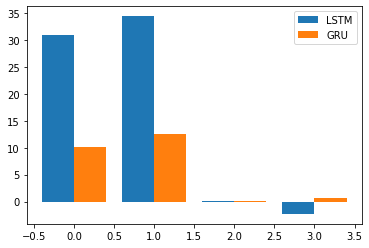

In [231]:
import matplotlib.pyplot as plt
x = np.arange(4)
width=0.40
plt.bar(x-0.2,y1,width)
plt.bar(x+0.2,y2,width)
plt.legend(["LSTM","GRU"])

In [220]:
all_tsla_data

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2010-06-29,23.89000,19.00000,25.00000,17.54000,23.89000,18766300
2010-06-30,23.83000,25.79000,30.42000,23.30000,23.83000,17187100
2010-07-01,21.96000,25.00000,25.92000,20.27000,21.96000,8218800
2010-07-02,19.20000,23.00000,23.10000,18.71000,19.20000,5139800
2010-07-06,16.11000,20.00000,20.00000,15.83000,16.11000,6866900
...,...,...,...,...,...,...
2020-01-28,566.90002,568.48999,576.81000,558.08002,566.90002,11788500
2020-01-29,580.98999,575.69000,589.79999,567.42999,580.98999,17801500
2020-01-30,640.81000,632.41998,650.88000,618.00000,640.81000,29005700
